## Methodology

- Train an autoencoder on all of the data available to be able to reconstruct any image with an identity
- accrue an average representation of all of the vangogh images in the latent space of this autoencoder
- accrue an average representation of all NON vangogh images in the latent space of the autoencoder

- v1
    - find the common values between all vangogh images and then take a weighted sum between that and the latent space of an arbitrary image
- v2
    - find the difference between the average vangogh image and the average image and then take a weighted sum between that and the latent space of an arbitrary image

## Version 1

In [1]:
import os
import PIL
import time
import imageio
import numpy as np
import tensorflow as tf
import tensorflow.data as tfd
import matplotlib.pyplot as pt

from glob import glob
from tqdm import tqdm
from typing import Iterable, List, Tuple, Any

In [2]:
def list_files(directory: str, search: Iterable) -> List[str]:
    """
    list files
    """
    if isinstance(search, str):
        search = [search]

    output: List[str] = []
    for term in search:
        for filepath in glob(os.path.join(directory, term)):
            output.append(filepath)

    return output

In [3]:
def load_random_image(directory: str, search: Iterable) -> np.ndarray:
    filepaths = list_files(directory, search)
    rand_index = np.random.randint(0, high=len(filepaths))
    return np.asarray(PIL.Image.open(filepaths[rand_index]))

## Dataset
- Train: 8868 images
- Test: 1697

In [4]:
data_dir = 'data'
random_image_dir = os.path.join(data_dir, 'random_images')
vangogh_image_dir = os.path.join(data_dir, 'vangogh_images')

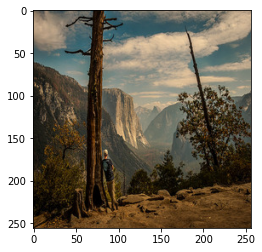

In [5]:
pt.imshow(load_random_image(random_image_dir, "*.jpg"))

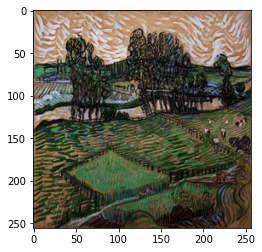

In [6]:
pt.imshow(load_random_image(vangogh_image_dir, "*.jpg"))

## Time to define the data generators

In [7]:
BATCH_SIZE = 64
BUFFER_SIZE = 64
DATASET_SIZE = len(list_files(random_image_dir, "*.jpg")) + len(list_files(vangogh_image_dir, "*.jpg"))

In [8]:
dgen_params = dict(
    rescale           =  1./255,
    shear_range       =  0.0,
    zoom_range        =  0.0,
    horizontal_flip   =  True,
    brightness_range  =  (0.95, 1.2),
    validation_split = 0.2,
)

gen_params = dict(
    target_size       =  (64, 64),
    batch_size        =  BATCH_SIZE,
    color_mode        =  'rgb',
    class_mode        =  'binary',
)

In [9]:
dgen = tf.keras.preprocessing.image.ImageDataGenerator(
    **dgen_params
)

train_gen = dgen.flow_from_directory(
    data_dir, 
    subset="training",
    **gen_params,
)

val_gen = dgen.flow_from_directory(
    data_dir, 
    subset="validation",
    **gen_params,
)

Found 16263 images belonging to 3 classes.
Found 4065 images belonging to 3 classes.


In [10]:
train_ds = tfd.Dataset.from_generator(lambda: train_gen, (tf.float32, tf.int32))
val_ds = tfd.Dataset.from_generator(lambda: val_gen, (tf.float32, tf.int32))

[2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


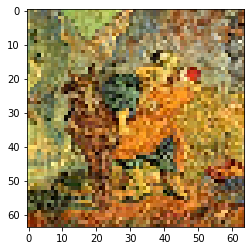

In [11]:
for img, label in train_ds.take(1).as_numpy_iterator():
    print(label)
    pt.imshow(img[0, ...])

[1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 2 1 1 2 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1]


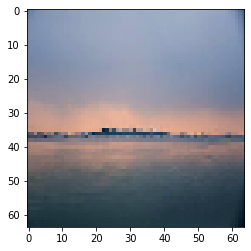

In [12]:
for img, label in val_ds.take(1).as_numpy_iterator():
    print(label)
    pt.imshow(img[0, ...])

## At this point, we know that our train and val generators contain our images which are labeled 1 for a random image and 2 for a vangogh image

In [13]:
from tensorflow.keras import layers
# from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.layers import Input, UpSampling2D, Conv2D, Conv2DTranspose, MaxPool2D, Dense, Reshape, LeakyReLU, Dropout, Flatten, Add, BatchNormalization

In [14]:
def downsampler_unit(input_tensor, num_features, filter_shape, strides_shape, padding, bias, max_pooling: bool = False):
    layer1 = Conv2D(num_features, filter_shape, strides=strides_shape, padding=padding, use_bias=bias)(input_tensor)
    layer2 = Conv2D(num_features, filter_shape, strides=(1, 1), padding=padding, use_bias=bias)(layer1)
    layer3 = BatchNormalization()(layer2)
    if max_pooling: 
        layer2 = MaxPool2D((2, 2))(layer2)
    layer2 = LeakyReLU()(layer2)

    return tf.keras.models.Model(inputs=input_tensor, outputs=layer3)

def upsampler_unit(input_tensor, scaling, filter_shape, strides_shape, padding, bias, batch_norm: bool = False):
    layer1 = UpSampling2D(strides_shape, interpolation='nearest')(input_tensor)
    layer2 = Conv2DTranspose(scaling, filter_shape, strides=(1, 1), padding=padding, use_bias=bias)(layer1)
    layer3 = Conv2DTranspose(scaling, filter_shape, strides=(1, 1), padding=padding, use_bias=bias)(layer2)
    if batch_norm:
        layer3 = BatchNormalization()(layer3)
    layer3 = LeakyReLU()(layer3)
    
    return tf.keras.models.Model(inputs=input_tensor, outputs=layer3)

def dense_unit(input_tensor, elements, use_bias):
    layer1 = Dense(elements)(input_tensor)
    return tf.keras.models.Model(inputs=input_tensor, outputs=layer1)

def latent_space_unit(input_tensor, latent_dim, dropout_pct):
    dropout = Dropout(dropout_pct)(input_tensor)
    flatten = Flatten()(dropout)
    latent_space = Dense(latent_dim)(flatten)

    return tf.keras.models.Model(inputs=input_tensor, outputs=latent_space)

In [15]:
class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.multiplier = 4
        self.latent_dim = 256*self.multiplier

        self.encoder_input = Input(shape=(64, 64, 3))
        print(tuple(self.encoder_input.get_shape()))
        self.ds1 = downsampler_unit(self.encoder_input, 128, (10, 10), (2, 2), 'same', False, False)
        print(self.ds1.output_shape)
        
        self.ds2 = downsampler_unit(Input(shape=self.ds1.output_shape[1:]), 64, (5, 5), (1, 1), 'same', True, False)
        print(self.ds2.output_shape)
        
        self.ds3 = downsampler_unit(Input(shape=(self.ds2.output_shape[1:])), 64, (4, 4), (2, 2), 'same', True, True)
        print(self.ds3.output_shape)
        
        self.d1 = dense_unit(Input(shape=(np.prod(self.ds3.output_shape[1:]),)), 256*4, True)
        print(self.d1.output_shape)
        
        self.latent_space = latent_space_unit(Input(shape=(self.d1.output_shape[1:])), self.latent_dim, 0.3)
        print(self.latent_space.output_shape)
        
        self.decoder_input = Input(shape=(16, 16, self.multiplier))
        self.up1 = upsampler_unit(self.decoder_input, 64, (1, 1), (2, 2), 'same', True, False)
        print(self.up1.output_shape)
        
        self.up2 = upsampler_unit(Input(shape=self.up1.output_shape[1:]), 128, (1, 1), (1, 1), 'same', True, False)
        print(self.up2.output_shape)
        
        self.up3 = upsampler_unit(Input(shape=self.up2.output_shape[1:]), 3, (1, 1), (2, 2), 'same', True, False)
        print(self.up3.output_shape)
        
    def plot_model_graph(self):
        tf.keras.utils.plot_model(
            tf.keras.models.Model(
                inputs=self.encoder_input, 
                outputs=self.call(self.encoder_input)), 
            'functional_components.png', 
            expand_nested=True, 
            show_shapes=True)
    
    def encode(self, image_batch, training):
        layer1 = self.ds1(image_batch)
        layer2 = self.ds2(layer1)
        layer3 = self.ds3(layer2)
        dense_in = Flatten()(layer3)
        if training:
            dense_in = Dropout(0.3)(dense_in)
        layer4 = self.d1(dense_in)
        latent_space = self.latent_space(layer4)
        
        return latent_space, layer1, layer2
    
    def decode(self, latent_space, skip1, skip2):
        reshape = Reshape((16, 16, self.multiplier))(latent_space)
        layer5 = self.up1(reshape)
        layer6 = Add()([skip2, layer5])
        layer6 = self.up2(layer6)
        layer7 = Add()([skip1, layer6])
        layer7 = self.up3(layer7)
        
        return layer7
    
    def call(self, image_batch, training: bool = False):
        latent_space, skip_layer1, skip_layer2 = self.encode(image_batch, training)
        return self.decode(latent_space, skip_layer1, skip_layer2)

In [16]:
autoencoder = Autoencoder()

(None, 64, 64, 3)
(None, 32, 32, 128)
(None, 32, 32, 64)
(None, 16, 16, 64)
(None, 1024)
(None, 1024)
(None, 32, 32, 64)
(None, 32, 32, 128)
(None, 64, 64, 3)


In [17]:
autoencoder.build(input_shape=(BATCH_SIZE, 64, 64, 3))
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 32, 32, 128)       1677312   
_________________________________________________________________
model_1 (Functional)         (None, 32, 32, 64)        307584    
_________________________________________________________________
model_2 (Functional)         (None, 16, 16, 64)        131456    
_________________________________________________________________
model_3 (Functional)         (None, 1024)              16778240  
_________________________________________________________________
model_4 (Functional)         (None, 1024)              1049600   
_________________________________________________________________
model_5 (Functional)         (None, 32, 32, 64)        4480      
_________________________________________________________________
model_6 (Functional)         (None, 32, 32, 128)       

In [18]:
autoencoder.plot_model_graph()

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [19]:
mse = tf.keras.losses.MSE

In [20]:
def autoencoder_loss(original_image, decoded_image):
    return mse(original_image, decoded_image)

In [21]:
autoencoder_optimizer = tf.keras.optimizers.RMSprop(lr=6e-6)

C:\Users\miked\anaconda3\envs\python_base\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [22]:
checkpoint_dir: str = 'autoencoder_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(autoencoder_optimizer=autoencoder_optimizer,
                                    autoencoder=autoencoder,
                                )

In [23]:
EPOCHS = 1
EPOCH_BATCHES = 2000

In [24]:
@tf.function
def train_step(images):
    loss = None
    with tf.GradientTape() as grad:
        autoencoded_images = autoencoder(images, training=True)
        loss = autoencoder_loss(images, autoencoded_images)
    gradients_of_autoencoder = grad.gradient(loss, autoencoder.trainable_variables)
    autoencoder_optimizer.apply_gradients(zip(gradients_of_autoencoder, autoencoder.trainable_variables))
    
    return loss

In [25]:
def train(images, epochs, epoch_batches, img):
    with tqdm(total=epochs*epoch_batches) as pbar:
        for epoch in range(epochs):
            start = time.time()
            for image, _ in images.take(epoch_batches):
                loss = tf.math.reduce_mean(tf.math.reduce_sum(train_step(image)))
                pbar.update(1)
            if (epoch+1) % 1 == 0:
#                 checkpoint.save(file_prefix=checkpoint_prefix)
                print(f'loss for epoch {epoch} : {loss}')
                autoencoder.save('model_red', save_format='tf')
                pt.imshow(autoencoder(img[0, ...].reshape(1, *img[0,...].shape))[0, ...])
                pt.savefig(f'epoch_output_reduced/{epoch}.png')
                pt.close()
        print(f"Time for epoch {epoch} is {time.time()-start}")

In [26]:
im  = []
for img, _ in train_ds.take(10).as_numpy_iterator():
    im.append(img[0, ...].reshape(1, *img[0,...].shape))

In [27]:
train(train_ds, EPOCHS, EPOCH_BATCHES, im[0])

100%|█████████████████████████████████████████████████████████████████████████████▉| 1999/2000 [02:32<00:00, 13.81it/s]

loss for epoch 0 : 3901.21826171875
INFO:tensorflow:Assets written to: model_red\assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:39<00:00, 12.51it/s]

Time for epoch 0 is 159.8799648284912


In [28]:
# for img, _ in train_ds.take(1).as_numpy_iterator():
#     pt.imshow(autoencoder(img[0, ...].reshape(1, *img[0,...].shape))[0, ...])

In [29]:
# autoencoder.save('model_300', save_format='tf')

In [30]:
newauto = tf.keras.models.load_model('model_red')

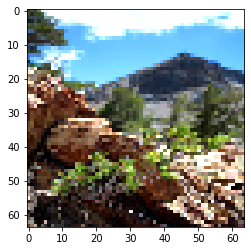

In [31]:
pt.imshow(im[0][0, ...])

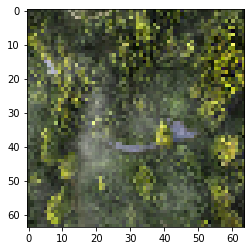

In [32]:
pt.imshow(im[2][0, ...])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


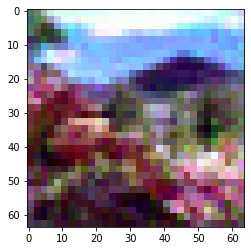

In [33]:
pt.imshow(autoencoder(im[0][0, ...].reshape(1, *im[0][0,...].shape))[0, ...])

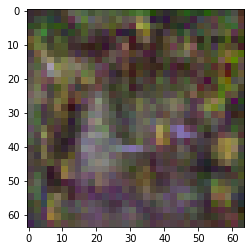

In [34]:
pt.imshow(autoencoder(im[2][0, ...].reshape(1, *im[2][0,...].shape))[0, ...])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


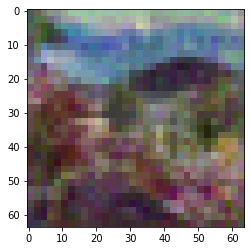

In [35]:
enc1, ski11, ski12 = autoencoder.encode(im[0][0, ...].reshape(1, *im[0][0,...].shape), training=False)
enc2, ski21, ski22 = autoencoder.encode(im[2][0, ...].reshape(1, *im[0][0,...].shape), training=False)

output = autoencoder.decode(enc1, (ski11 + ski21) * 0.5, (ski12 + ski22)*0.5).numpy()
pt.imshow(output.reshape(*output[0, ...].shape))

In [36]:
# class Autoencoder(tf.keras.Model):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         self.multiplier = 8
#         self.latent_dim = 256*self.multiplier

#         self.encoder_input = Input(shape=(64, 64, 3))
#         print(tuple(self.encoder_input.get_shape()))
#         self.ds1 = downsampler_unit(self.encoder_input, 8, (10, 10), (2, 2), 'same', False, False)
#         print(self.ds1.output_shape)
        
#         self.ds2 = downsampler_unit(Input(shape=self.ds1.output_shape[1:]), 16, (5, 5), (1, 1), 'same', True, False)
#         print(self.ds2.output_shape)
        
#         self.ds3 = downsampler_unit(Input(shape=(self.ds2.output_shape[1:])), 32, (5, 5), (2, 2), 'same', True, True)
#         print(self.ds3.output_shape)
        
#         self.ds4 = downsampler_unit(Input(shape=(self.ds3.output_shape[1:])), 32, (3, 3), (1, 1), 'same', True, True)
#         print(self.ds3.output_shape)
# #         self.d1 = dense_unit(Input(shape=(np.prod(self.ds3.output_shape[1:]),)), 256*8, True)
# #         print(self.d1.output_shape)
        
# #         self.d2 = dense_unit(Input(shape=(self.d1.output_shape[1:])), 256*4, True)
# #         print(self.d2.output_shape)
        
#         self.latent_space = latent_space_unit(Input(shape=(self.ds3.output_shape[1:])), self.latent_dim, 0.3)
#         print(self.latent_space.output_shape)
        
#         self.decoder_input = Input(shape=(16, 16, self.multiplier))
#         self.up1 = upsampler_unit(self.decoder_input, 16, (1, 1), (2, 2), 'same', True, False)
#         print(self.up1.output_shape)
        
#         self.up2 = upsampler_unit(Input(shape=self.up1.output_shape[1:]), 8, (1, 1), (1, 1), 'same', True, False)
#         print(self.up2.output_shape)
        
#         self.up3 = upsampler_unit(Input(shape=self.up2.output_shape[1:]), 3, (1, 1), (2, 2), 'same', True, False)
#         print(self.up3.output_shape)
        
#     def plot_model_graph(self):
#         tf.keras.utils.plot_model(
#             tf.keras.models.Model(
#                 inputs=self.encoder_input, 
#                 outputs=self.call(self.encoder_input)), 
#             'functional_components_reduced.png', 
#             expand_nested=True, 
#             show_shapes=True)
    
#     def encode_image(self, image):
#         layer1 = self.ds1(image_batch)
#         layer2 = self.ds2(layer1)
#         layer3 = self.ds3(layer2)
#         latent_space = self.latent_space(layer3)
        
#         return latent_space
    
#     def call(self, image_batch, training: bool = False, full_pipeline: bool = True, encode_only: bool = False, decode_only: bool = False):
#         if full_pipeline or encode_only:
#             layer1 = self.ds1(image_batch)

#             layer2 = self.ds2(layer1)

#             layer3 = self.ds3(layer2)

# #             dense_in = Flatten()(layer3)

# #             if training:
# #                 dense_in = Dropout(0.3)(dense_in)

#             layer4 = self.ds4(layer3)

#     #         layer5 = self.d2(layer4)

#             latent_space = self.latent_space(layer4)
#             if encode_only:
#                 return latent_space
#         if full_pipeline or decode_only:
#             if decode_only: 
#                 latent_space = image_batch
                
#             reshape = Reshape((16, 16, self.multiplier))(latent_space)

#             layer5 = self.up1(reshape)

#             skip_connnection1 = Add()([layer2, layer5])

#             layer6 = self.up2(layer5)

#             skip_connection2 = Add()([layer1, layer6])

#             layer7 = self.up3(layer6)
        
#             return layer7